# Team Helmberger: Reddit sentiment analysis & machine learning classifier to distinguish between questions tagged as positive/negative

## Libraries and API Access

### We start by importing the necessary libraries. These include praw, nltk and pyspark. We then move on to set up a praw access to the Reddit API, using the client id, client secret and user agent provided by reddit when we applied for developer rights.

In [1]:
import sys
!{sys.executable} -m pip install praw
import sys
!{sys.executable} -m pip install nltk
import sys
!{sys.executable} -m pip install pyspark
# import reddit api wrapper 
import praw
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Set up PRAW to access Reddit API
reddit = praw.Reddit(client_id='XXXXXXXXXXXX', client_secret='XXXXXXXXXXXXXX', user_agent='XXXXXXXXX')

### Now, we select the top 100 subreddits from r/all filtered by 'hot' and store them in a list. We then remove all the diuplicates and check the output.

In [2]:
# empty list which will store subreddits
subreddit_names =[]
for submission in reddit.subreddit('all').hot(limit=100):
    #print(submission.subreddit.display_name)
    subreddit_names.append(submission.subreddit.display_name)

#print(subreddit_names)
# removing duplicates
subreddit_names = list(set(subreddit_names))
print(subreddit_names)

['technicallythetruth', 'blursedimages', 'BetterEveryLoop', 'MapPorn', 'fightporn', 'tifu', 'TIHI', 'interestingasfuck', 'Whatcouldgowrong', 'wholesomememes', 'oddlyterrifying', 'Damnthatsinteresting', 'lgbt', 'WitchesVsPatriarchy', 'pcgaming', 'ChoosingBeggars', 'pcmasterrace', 'antiwork', 'LifeProTips', 'todayilearned', 'Unexpected', 'ShitPostCrusaders', 'StarWars', 'australia', 'me_irlgbt', 'perfectlycutscreams', 'facepalm', 'ShittyLifeProTips', 'nextfuckinglevel', 'meirl', 'pics', 'news', 'NonPoliticalTwitter', 'food', 'Wellthatsucks', 'tumblr', 'PixelArt', 'gifs', 'lego', 'clevercomebacks', 'science', 'ContagiousLaughter', 'politics', 'ich_iel', 'nba', 'worldnews', 'balkans_irl', 'me_irl', 'educationalgifs', 'agedlikemilk', 'MurderedByWords', 'MadeMeSmile', 'instant_regret', 'AnimalCrossing', 'TheLastAirbender', 'ProgrammerHumor', 'comics', 'AbsoluteUnits', 'BikiniBottomTwitter', 'Terraria', 'CatastrophicFailure', 'natureismetal', 'europe', 'cats', 'Superstonk', 'funny', 'BlackPeo

### Using the subreddits extracted, we select the top 100 posts from these subreddits filtered by 'hot'. This might take some time (a few minutes) due to the amount of posts, however the limit can be set to up to 1000 for a single request (for both subreddits and posts of those subreddits). The amount of requests can be adjusted as needed by the user (repeating the code).

### During the early stages of the project, we encountered many Server Errors while extracting the posts. We believe that this is because we made too many requests to the server (naturally, as we were testing the beginning part of our code) and that reddit did not like this. It could have also had something to do with the fact that we started off by setting the limit to None. Nonetheless, the problem never returned.

In [3]:
# Create an empty list to store the subreddit data
subreddit_data = []

# Scrape the data for each subreddit
for subreddit_name in subreddit_names:
    subreddit = reddit.subreddit(subreddit_name)
    for submission in subreddit.hot(limit=100):
        subreddit_data.append((subreddit_name, submission.title, submission.selftext))

#print(subreddit_data)


## Pyspark

### We initialize pyspark and build a session, then create a dataframe using the reddit post data.

In [4]:
# Import the findspark module 
import findspark

# Initialize via the full spark path
findspark.init('/usr/local/spark/')

In [5]:
# Import the spark sql and sql.types, and sql.functions, and time modules 
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import col, split
import time

# Gets an existing :class:`SparkSession` or, if there is no existing one, creates a
# new one based on the options set in this builder.
spark = SparkSession.builder \
   .master('local[*]') \
   .appName('RedditApp') \
   .config('spark.executor.memory', '1gb') \
   .getOrCreate()

sc = spark.sparkContext

In [6]:
# Create a PySpark DataFrame from the subreddit data
subreddit_df = spark.createDataFrame(subreddit_data, ['subreddit', 'title', 'text'])


subreddit_df.take(10)


[Row(subreddit='technicallythetruth', title='A new way to consider the alphabet.', text=''),
 Row(subreddit='technicallythetruth', title='Well that is what she asked for...', text=''),
 Row(subreddit='technicallythetruth', title='Dracula looks different from the source material', text=''),
 Row(subreddit='technicallythetruth', title='Where woof come out', text=''),
 Row(subreddit='technicallythetruth', title='The alphabet in alphabetical order', text=''),
 Row(subreddit='technicallythetruth', title='Don’t forget the pudding cup', text=''),
 Row(subreddit='technicallythetruth', title='He’s got a point', text=''),
 Row(subreddit='technicallythetruth', title='On a post saying that your Reddit karma is how many seconds you have left to live', text=''),
 Row(subreddit='technicallythetruth', title='make adversaries great again', text=''),
 Row(subreddit='technicallythetruth', title='I guess that is what it tastes like', text='')]

In [7]:
#subreddit_df = subreddit_df.dropna()
subreddit_df.count()

8900

## Cleaning the text

### The count and the output so far make sense. We move on to cleaning the title text for more accurate results.

### We first tried using the cleaning functions used in class, however they did not work for us. Therefore, we adapted code we found online and it worked for our purposes. However, we first needed to turn the title column of our dataframe into a list in order to use the cleanText and de_emojifier functions, and then put the new title column back into the dataframe.

### Source: https://medium.com/@kiddojazz/reddit-sentiment-analysis-f8a1a790124a

In [8]:
# cleaning the text

from pyspark.sql.functions import udf, monotonically_increasing_id
import re

def cleanText(text):
    text = re.sub(r'@[A-Za-z0–9]+', '', text) 
    text = re.sub(r'#', '', text) 
    text = re.sub(r'RT[\s]+', '', text) 
    text = re.sub(r'http\S+', '', text) 
    text = re.sub(r':', '', text)
    text = re.sub(r'\*', '', text)
    text = re.sub(r'\n', '', text)
    return text

# turning 'title' into a list
li = subreddit_df.rdd.map(lambda x: x[1]).collect()
#print(li)

title = []
for l in li:
    title.append(cleanText(l))

# turn title back into the dataframe column

subreddit_df = subreddit_df.repartition(1).withColumn(
    'title', 
    udf(lambda id: title[id])(monotonically_increasing_id()))

## removing emojis

def de_emojifier(string):
    emoji_pat = re.compile('['
    u'\U0001F600-\U0001F64F'
    u'\U0001F300-\U0001F5FF'
    u'\U0001F680-\U0001F6FF'
    u'\U0001F1E0-\U0001F1FF'
    u'\U00002500-\U00002BEF'
    u'\U00002702-\U000027B0'
    u'\U00002702-\U000027B0'
    u'\U000024C2-\U0001F251'
    u'\U0001f926-\U0001f937'
    u'\U00010000-\U0010ffff'
    u'\u2640-\u2642'
    u'\u2600-\u2B55'
    u'\u200d'
    u'\u23cf'
    u'\u23e9'
    u'\u231a'
    u'\ufe0f'
    u'\u3030'
    ']+', flags=re.UNICODE)
    return emoji_pat.sub(r'', string)

# bye emojis
title = []
for l in li:
    title.append(de_emojifier(l))
    

# putting title back into the dataframe

subreddit_df = subreddit_df.repartition(1).withColumn(
    'title', 
    udf(lambda id: title[id])(monotonically_increasing_id()))


#Show the clean text
subreddit_df.show()

+-------------------+--------------------+----+
|          subreddit|               title|text|
+-------------------+--------------------+----+
|technicallythetruth|A new way to cons...|    |
|technicallythetruth|Well that is what...|    |
|technicallythetruth|Dracula looks dif...|    |
|technicallythetruth| Where woof come out|    |
|technicallythetruth|The alphabet in a...|    |
|technicallythetruth|Don’t forget the ...|    |
|technicallythetruth|    He’s got a point|    |
|technicallythetruth|On a post saying ...|    |
|technicallythetruth|make adversaries ...|    |
|technicallythetruth|I guess that is w...|    |
|technicallythetruth|Toy Guns > Real Guns|    |
|technicallythetruth|Amazing life tip ...|    |
|technicallythetruth|oh wow, i didn’t ...|    |
|technicallythetruth|Every man is a ma...|    |
|technicallythetruth|How to brighten t...|    |
|technicallythetruth|So, about that ea...|    |
|technicallythetruth|  He is right indeed|    |
|technicallythetruth|Some police offic..

### The title column looks okay, and there seem to be no emojis or other unecessary text. We move on to sentiment analysis.

## But first - making tokens for later

### Part of our goal will be to train a machine learning classifier to distinguish between questions tagged as positive and negative using the text of the reddit post title. The resulting classifier represents a first step towards a system that can automatically categorize new incoming posts.

### We import some necessary functions. We then create some helper functions which will help make a new dataframe column which includes the processed reddit post titles, turned into tokens for analysis. We aagin turn the title column into a list, use the functions on the list, and then put it back into the dataframe.

In [9]:
### nltk 
import string
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk.corpus import shakespeare

# This code is largely from the Data Science 4 course with Professor Johannes Wachs

lemmatizer = WordNetLemmatizer()
ps = PorterStemmer() 
en_stopwords= stopwords.words('english')

def get_wordnet_pos(token):
    '''Helper function: map POS tag to first character lemmatize() accepts
    Taken from: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
    '''
    tag = nltk.pos_tag([token])[0][1][0].upper() #extract the information
    tag_dict = {'J': wordnet.ADJ, #map
                'N': wordnet.NOUN,
                'V': wordnet.VERB,
                'R': wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN) #guess noun if unknown


def processing_pipeline(text):
    '''takes a sentence and returns a lowercased, lemmatized, and stemmed list of tokens'''
    tokens=nltk.word_tokenize(text)
    lemmatized_tokens=[lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
    stemmed_tokens =[ps.stem(token) for token in lemmatized_tokens]
    processed_tokens = [token for token in stemmed_tokens if token not in en_stopwords]
    processed_tokens = [token for token in processed_tokens if token not in string.punctuation]
    return processed_tokens


In [10]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
myL = subreddit_df.rdd.map(lambda x: x[1]).collect()
#print(myL)

processed_title = []
for l in myL:
    processed_title.append(processing_pipeline(l))
    
#print(processed_title)

In [12]:
from pyspark.sql.functions import udf, monotonically_increasing_id

df = subreddit_df.repartition(1).withColumn(
    'processed_title', 
    udf(lambda id: processed_title[id])(monotonically_increasing_id()))

df.show()

+-------------------+--------------------+----+--------------------+
|          subreddit|               title|text|     processed_title|
+-------------------+--------------------+----+--------------------+
|technicallythetruth|A new way to cons...|    |[new, way, consid...|
|technicallythetruth|Well that is what...|    |    [well, ask, ...]|
|technicallythetruth|Dracula looks dif...|    |[dracula, look, d...|
|technicallythetruth| Where woof come out|    |        [woof, come]|
|technicallythetruth|The alphabet in a...|    |[alphabet, alphab...|
|technicallythetruth|Don’t forget the ...|    |[’, forget, pud, ...|
|technicallythetruth|    He’s got a point|    |     [’, get, point]|
|technicallythetruth|On a post saying ...|    |[post, say, reddi...|
|technicallythetruth|make adversaries ...|    |[make, adversari,...|
|technicallythetruth|I guess that is w...|    | [guess, tast, like]|
|technicallythetruth|Toy Guns > Real Guns|    |[toy, gun, real, ...|
|technicallythetruth|Amazing life 

### We look at the frequency of tokens just for fun. Back when we first started testing 'zelenski', 'year' and 'christmas' were very common tokens. Now, the tokens seem to be more genreral in nature.

In [13]:
## first turn the processed titles into a flat list and then do a frequency distribution to see most common words used

flat_list = [item for sublist in processed_title for item in sublist]
fd = nltk.FreqDist(flat_list)
fd.most_common(50)
## besides common verbs, christmas and zelenski are used, as well as year and house. seems like the ukraine war as well as the
## upcoming holidays are influencing this

[('thi', 757),
 ('’', 695),
 ("'s", 484),
 ('get', 352),
 ('make', 259),
 ("n't", 253),
 ("''", 246),
 ('``', 236),
 ('like', 233),
 ('new', 229),
 ('one', 222),
 ('hi', 206),
 ('go', 191),
 ('time', 181),
 ('say', 177),
 ('...', 174),
 ('oc', 173),
 ('year', 170),
 ('day', 158),
 ('first', 144),
 ('look', 140),
 ('work', 137),
 ('take', 135),
 ('thank', 133),
 ('game', 131),
 ('use', 128),
 ('peopl', 127),
 ('”', 126),
 ('“', 122),
 ('know', 121),
 ('hate', 121),
 ('want', 114),
 ('good', 110),
 ('see', 107),
 ('turkey', 106),
 ('found', 106),
 ('today', 103),
 ('til', 102),
 ('lpt', 102),
 ('earthquak', 101),
 ('tifu', 100),
 ('well', 98),
 ('love', 98),
 ('old', 97),
 ('slpt', 97),
 ('would', 96),
 ('whi', 96),
 ('cat', 94),
 ('meirl', 94),
 ('guy', 93)]

## Sentiment analysis

### Using the nltk sentiment intensity analyzer function, we will make 4 new columns which include the polarity scores of each post and append them to the dataframe. The most important column will be the 'compound' column, which indicates the compound polarity score of each post.

### At first, we use the sentiment analzyer function on our title list, and then turn it into a dataframe of its own and inner join it to the other dataframe. Here we had some probelems perfecting the inner join, as the scores did not seem to match the titles at first. Some Stack Overflow help was needed, and at the end we used a function from this question: https://stackoverflow.com/questions/40508489/spark-merge-2-dataframes-by-adding-row-index-number-on-both-dataframes in order to correctly map each post with its respective polarity scores.

In [14]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [15]:
# playing with sentiment analyzer

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

#for post in myL:
#    print(sia.polarity_scores(post), post

res=[]
for l in myL:
    res.append(sia.polarity_scores(l))
    

In [16]:
sentiment_df = spark.createDataFrame(res)
sentiment_df.take(26)

/usr/local/spark/python/pyspark/sql/session.py:381: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"


[Row(compound=0.0, neg=0.0, neu=1.0, pos=0.0),
 Row(compound=0.2732, neg=0.0, neu=0.741, pos=0.259),
 Row(compound=0.0, neg=0.0, neu=1.0, pos=0.0),
 Row(compound=0.0, neg=0.0, neu=1.0, pos=0.0),
 Row(compound=0.0, neg=0.0, neu=1.0, pos=0.0),
 Row(compound=-0.2263, neg=0.322, neu=0.678, pos=0.0),
 Row(compound=0.0, neg=0.0, neu=1.0, pos=0.0),
 Row(compound=0.0, neg=0.0, neu=1.0, pos=0.0),
 Row(compound=0.4767, neg=0.247, neu=0.247, pos=0.506),
 Row(compound=0.3612, neg=0.0, neu=0.706, pos=0.294),
 Row(compound=0.0, neg=0.0, neu=1.0, pos=0.0),
 Row(compound=0.5859, neg=0.0, neu=0.648, pos=0.352),
 Row(compound=0.5859, neg=0.0, neu=0.513, pos=0.487),
 Row(compound=0.0, neg=0.0, neu=1.0, pos=0.0),
 Row(compound=0.4404, neg=0.0, neu=0.707, pos=0.293),
 Row(compound=0.0, neg=0.0, neu=1.0, pos=0.0),
 Row(compound=0.0, neg=0.0, neu=1.0, pos=0.0),
 Row(compound=0.4019, neg=0.0, neu=0.838, pos=0.162),
 Row(compound=0.0, neg=0.0, neu=1.0, pos=0.0),
 Row(compound=0.0, neg=0.0, neu=1.0, pos=0.0),
 

In [17]:
from pyspark.sql.types import StructType, StructField, LongType

def with_column_index(sdf): 
    new_schema = StructType(sdf.schema.fields + [StructField('ColumnIndex', LongType(), False),])
    return sdf.rdd.zipWithIndex().map(lambda row: row[0] + (row[1],)).toDF(schema=new_schema)

df1_ci = with_column_index(df)
df2_ci = with_column_index(sentiment_df)
reddit_sentiment = df1_ci.join(df2_ci, df1_ci.ColumnIndex == df2_ci.ColumnIndex, 'inner').drop('ColumnIndex')
reddit_sentiment.show()
reddit_sentiment.select(count(reddit_sentiment.neu)).show()

+-------------------+--------------------+--------------------+--------------------+--------+-----+-----+-----+
|          subreddit|               title|                text|     processed_title|compound|  neg|  neu|  pos|
+-------------------+--------------------+--------------------+--------------------+--------+-----+-----+-----+
|technicallythetruth|That's one way to...|                    | ['s, one, way, put]|     0.0|  0.0|  1.0|  0.0|
|technicallythetruth|The problems of s...|                    |[problem, short, ...| -0.4019|0.403|0.597|  0.0|
|          fightporn|Guy in blue claim...|                    |[guy, blue, claim...|     0.0|  0.0|  1.0|  0.0|
|     wholesomememes|Always nice, seei...|                    |[alway, nice, see...|  0.4215|  0.0|0.682|0.318|
|       pcmasterrace|   Motherboard shot?|Am trying to buil...| [motherboard, shot]|     0.0|  0.0|  1.0|  0.0|
|       pcmasterrace|2 Questions: is m...|                    |[2, question, fan...|  0.6597|  0.0|0.652

## Labeling each post, based on its score

### Using the 0.05 threshold recommended by the VADER github readme (https://github.com/cjhutto/vaderSentiment#about-the-scoring), we label each post with 0 (neg), 1 (pos) or 2 (neu), based on whether the polarity score indicates negativity, positivity or neutrality, respectively.

In [18]:
THRESHOLD = 0.05

df.printSchema()


from pyspark.sql.functions import when
from pyspark.sql import functions as F

#reddit_sentiment1 = reddit_sentiment.withColumn('label', (when(col('compound') <= -THRESHOLD, 0).when(col('compound') >= THRESHOLD, 1).otherwise(2)))
reddit_sentiment1 = reddit_sentiment.withColumn('label', (when(col('compound') <= -THRESHOLD, 0).when(col('compound') >= THRESHOLD, 1).otherwise(2)))


reddit_sentiment1.show()

root
 |-- subreddit: string (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- processed_title: string (nullable = true)

+-------------------+--------------------+--------------------+--------------------+--------+-----+-----+-----+-----+
|          subreddit|               title|                text|     processed_title|compound|  neg|  neu|  pos|label|
+-------------------+--------------------+--------------------+--------------------+--------+-----+-----+-----+-----+
|technicallythetruth|That's one way to...|                    | ['s, one, way, put]|     0.0|  0.0|  1.0|  0.0|    2|
|technicallythetruth|The problems of s...|                    |[problem, short, ...| -0.4019|0.403|0.597|  0.0|    0|
|          fightporn|Guy in blue claim...|                    |[guy, blue, claim...|     0.0|  0.0|  1.0|  0.0|    2|
|     wholesomememes|Always nice, seei...|                    |[alway, nice, see...|  0.4215|  0.0|0.682|0.318|    1|
|      

### For our purposes, neutral posts are not needed, so we remove those and do a count to see if everything fits.

In [19]:
reddit_sentiment1.groupBy('label').count().show()

from pyspark.sql.functions import count
reddit_sentiment1.select(count(reddit_sentiment1.label)).show()
allSentiments = reddit_sentiment1

# drop rows with neutral sentiment
reddit_sentiment1 = reddit_sentiment1.where(reddit_sentiment1.label!=2)
reddit_sentiment1.select(count(reddit_sentiment1.label)).show()

reddit_sentiment1.show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 2233|
|    2| 4752|
|    0| 1915|
+-----+-----+

+------------+
|count(label)|
+------------+
|        8900|
+------------+

+------------+
|count(label)|
+------------+
|        4148|
+------------+

+-------------------+--------------------+--------------------+--------------------+--------+-----+-----+-----+-----+
|          subreddit|               title|                text|     processed_title|compound|  neg|  neu|  pos|label|
+-------------------+--------------------+--------------------+--------------------+--------+-----+-----+-----+-----+
|technicallythetruth|The problems of s...|                    |[problem, short, ...| -0.4019|0.403|0.597|  0.0|    0|
|     wholesomememes|Always nice, seei...|                    |[alway, nice, see...|  0.4215|  0.0|0.682|0.318|    1|
|       pcmasterrace|2 Questions: is m...|                    |[2, question, fan...|  0.6597|  0.0|0.652|0.348|    1|
|        LifeProTips|LPT Request: What...

### Observing the Top 10 Subreddits for negative and positive sentiment:

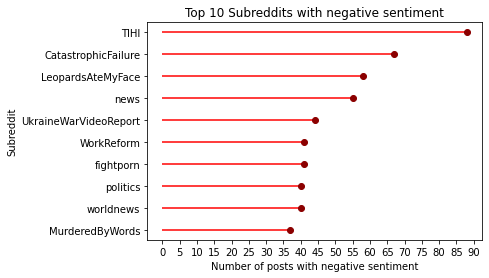

In [20]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

dfNegative = reddit_sentiment1.filter(col("label")==0).groupBy("subreddit").count().alias("count").sort(desc("count")).limit(10).toPandas()
dfNegative = dfNegative.sort_values(by='count')

fig, axes = plt.subplots()
plt.hlines(y=dfNegative['subreddit'], xmin=0, xmax=dfNegative['count'], color='red')  

# formatting and details
plt.xlabel('Number of posts with negative sentiment')
plt.ylabel('Subreddit')
plt.title('Top 10 Subreddits with negative sentiment')
plt.xticks(np.arange(0, dfNegative['count'].max() + 5, 5.0))

axes.plot(dfNegative['count'], dfNegative['subreddit'], "o", c='darkred')

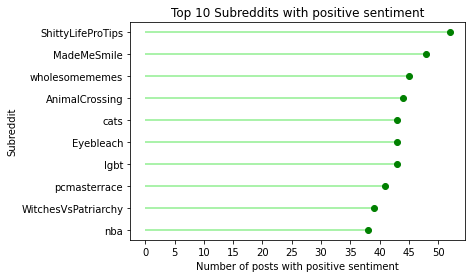

In [21]:
dfPositive = reddit_sentiment1.filter(col("label")==1).groupBy("subreddit").count().alias("count").sort(desc("count")).limit(10).toPandas()
dfPositive = dfPositive.sort_values(by='count')

fig, axes = plt.subplots()
plt.hlines(y=dfPositive['subreddit'], xmin=0, xmax=dfPositive['count'], color='lightgreen')  

# formatting and details
plt.xlabel('Number of posts with positive sentiment')
plt.ylabel('Subreddit')
plt.title('Top 10 Subreddits with positive sentiment')
plt.xticks(np.arange(0, dfPositive['count'].max() + 5, 5.0))

axes.plot(dfPositive['count'], dfPositive['subreddit'], "o", c='green')

### Observing the overall sentiment:

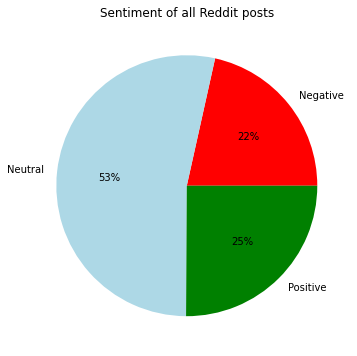

,label,count
2,Negative,1915
1,Neutral,4752
0,Positive,2233


In [22]:
dfAllSentiments = allSentiments.groupBy("label").count().alias("count").toPandas()
dfAllSentiments.loc[dfAllSentiments['label'] == 0, 'label'] = 'Negative'
dfAllSentiments.loc[dfAllSentiments['label'] == 1, 'label'] = 'Positive'
dfAllSentiments.loc[dfAllSentiments['label'] == 2, 'label'] = 'Neutral'

# order by the label name so the color always fits the right sentiment
dfAllSentiments = dfAllSentiments.sort_values(by='label')

colors = ['red', 'lightblue', 'green']

plt.figure(figsize=(8, 6))
plt.pie(dfAllSentiments['count'], labels=dfAllSentiments['label'], autopct='%1.0f%%', colors=colors)
plt.title("Sentiment of all Reddit posts")
plt.show()
dfAllSentiments

## Accuracy models

### We apply Natural Language Proccesing in order to evaluate the performance and accuracy of our model. 

### The first step will be to create a corpus and initialize a TF-IDF DTM.

In [23]:
myL=reddit_sentiment1.rdd.map(lambda x: x[1]).collect()
#print(myL)

processed_title = []
for l in myL:
    processed_title.append(processing_pipeline(l))


from sklearn.feature_extraction.text import TfidfVectorizer
corpus= list([' '.join(text) for text in processed_title])
#print(corpus)
vectorizer = TfidfVectorizer(min_df=10, max_df=.5) 
#keep only those tokens in at least 10 documents, and in at most 50% of documents

DTM=vectorizer.fit_transform(corpus)
print(DTM.toarray())
print(DTM.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(4148, 679)


### We now have a document-term matrix, weighted via TF-IDF. The shape looks good, meaning we are free to move on

In [24]:
y = np.array(reddit_sentiment1.select('label').collect())
y = y.reshape(-1)
print(y.shape)
y

(4148,)


array([0, 1, 1, ..., 1, 1, 1])

## First, let us create a test-train split

### We want to evaluate our algorithm on data that it hasn't seen before, to prevent overfitting.

In [25]:
# sklearn provides various functionalities to crossvalidate model performance
from sklearn.model_selection import train_test_split

# randomly split data into training and test
X_train, X_test, y_train, y_test = train_test_split(DTM, y, test_size=.3, random_state=42)

print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(2903, 679) (1245, 679)
(2903,) (1245,)


### First we fit a penalized logistic regression

Accuracy:
0.7526104417670683
--------
Confusion Matrix:
[[450 138]
 [170 487]]
--------
AUC score:
0.8458308742066081


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Text(0, 0.5, 'True Positive Rate')

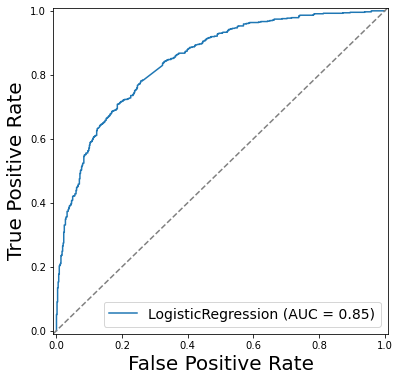

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


reg = LogisticRegression(penalty='l1',solver='saga',C=10)
reg.fit(X_train, y_train)
y_pred = reg.predict_proba(X_test)[:,1]

print('Accuracy:')
print((accuracy_score(y_test, reg.predict(X_test))))
print('--------')
print('Confusion Matrix:')
print(confusion_matrix(y_test, reg.predict(X_test)))
print('--------')
print('AUC score:')
print((roc_auc_score(y_test,y_pred)))

f,ax=plt.subplots(1,figsize=(6,6))
plot_roc_curve(reg, X_test, y_test,ax=ax)
ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='grey',linestyle='--')
plt.xlim([-.01,1.01])
plt.ylim([-.01,1.01])
plt.legend(prop={'size':14})
plt.xlabel('False Positive Rate',size=20)
plt.ylabel('True Positive Rate',size=20)

### The baseline accuracy while always guessing negative seems to usually be around 50-60%, meaning that our models offers an improvement in accuracy.

### A great thing about the Lasso (L1 penalty) is that it shrinks many of the estimated coefficients on the individual features to 0. The remaining features with relatively large coefficients are the important ones - we can look at what tokens those are:

In [27]:
#we access these from the model object reg
#take the absolute value
top_positive_coefficients = pd.Series(reg.coef_[0]).sort_values(ascending=False).head(10)
top_negative_coefficients = pd.Series(reg.coef_[0]).sort_values(ascending=False).tail(10)
top_positive_coefficients,top_negative_coefficients

(353    14.358383
 125    12.826715
 303    12.778479
 263    11.082735
 431    10.722589
 659    10.582107
 459    10.497376
 450    10.289460
 326     9.324090
 437     9.233612
 dtype: float64,
 642    -9.292145
 526   -10.317872
 454   -11.244455
 70    -11.481450
 644   -12.161481
 316   -12.185585
 63    -12.477033
 273   -12.674578
 211   -13.905771
 390   -16.074128
 dtype: float64)

In [28]:
print('Top features predicting relevance to the case')

for x in top_positive_coefficients.index:
    print(vectorizer.get_feature_names()[x])
    
print('--------')
print('Top features predicting irrelevance to the case')

for x in top_negative_coefficients.index:
    print(vectorizer.get_feature_names()[x])

Top features predicting relevance to the case
love
clear
interest
great
parti
win
pretti
pleas
laugh
perfect
--------
Top features predicting irrelevance to the case
war
sever
poor
ban
wast
kill
avoid
hate
failur
murder


#### analysing the top features we observe that it makes sense

### In order to compare the accuracies of different models, we will now try a random forrest classifier with 500 trees 

0.7734939759036145
--------
Confusion Matrix:
[[463 125]
 [157 500]]
--------
0.8573188788452977


Text(0, 0.5, 'True Positive Rate')

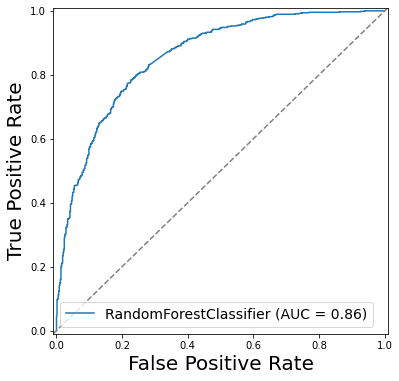

In [29]:
# let's try a random forest classifier, with 500 trees

from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=500)
RF.fit(X_train, y_train)
y_pred = RF.predict_proba(X_test)[:,1]

print((accuracy_score(y_test, RF.predict(X_test))))
print('--------')
print('Confusion Matrix:')
print(confusion_matrix(y_test, RF.predict(X_test)))
print('--------')
print((roc_auc_score(y_test,y_pred)))

f,ax=plt.subplots(1,figsize=(6,6))
plot_roc_curve(RF, X_test, y_test,ax=ax)
ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='grey',linestyle='--')
plt.xlim([-.01,1.01])
plt.ylim([-.01,1.01])
plt.legend(prop={'size':14})
plt.xlabel('False Positive Rate',size=20)
plt.ylabel('True Positive Rate',size=20)

### From our tests, we usually noticed a very small increase/decrease in accuracy.

### Inspired by https://towardsdatascience.com/sentiment-analysis-with-pyspark-bc8e83f80c35, we will also try out HashingTF + IDF + Logistic Regression:

In [30]:
(train_set, val_set, test_set) = reddit_sentiment1.randomSplit([0.8, 0.1, 0.1], seed = 2000)

In [31]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol='title', outputCol='words')
hash_tf = HashingTF(numFeatures=2**16, inputCol='words', outputCol='tf')
idf = IDF(inputCol='tf', outputCol='features', minDocFreq=5) #minDocFreq removes sparse terms
label_string_Idx = StringIndexer(inputCol = 'label', outputCol = 'label1')
pipeline = Pipeline(stages=[tokenizer, hash_tf, idf, label_string_Idx])

pipelineFit = pipeline.fit(train_set)
train_df = pipelineFit.transform(train_set)
val_df = pipelineFit.transform(val_set)
#train_df.show(5)

In [32]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter=100)
lrModel = lr.fit(train_df)
predictions = lrModel.transform(val_df)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction')
evaluator.evaluate(predictions)

0.72608547008547

### This accuracy score seems the best at first, however as noted by Ricky, BinaryClassificationEvaluator evaluates by default areaUnderROC. We took his recommendation and calculate accuracy by counting the number of predictions matching the label and dividing it by the total entries.

In [33]:
# accuracy calculation
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
accuracy

0.6571428571428571

### The accuracy of this test seems to increase/decrease by a few percentage points based on the reddit posts. During our last test, it decreased.

### The points made during the accuracy tests are what we noticed during our test. In reality, these accuraxy scores tend to change, as the reddit posts extracted change each time the whole notebook is ran.